# Titanic Dataset Exploration

# To Do

1. Add a table of contents
2. Add in other models for comparison: Linear, Tree, Random Forest, XGBoost (nah, XGBoost is bad and slow), Neural Net
3. Generate more features (Group Size)
4. Scale data, probably normal distribution
5. Further hyperparameter tuning, and learn about what all the model parameters do
6. Discuss Explainability in the model (feature importance is a big part of this, but perhaps also use LIME or other perturbation analysis)
7. Add a description of the linear model
8. PCA

# Introduction

Hello. My name is Evan Freeman. Here's my analysis of the passengers of the Titanic.  I'm going to create a machine learning model to predict whether or not a passenger survived based on information like sex, class, and age.

I'm working on this Kaggle competition:  
https://www.kaggle.com/c/titanic/overview

Also, in general, when I've looked up information on the passengers, it's been through:  
https://www.encyclopedia-titanica.org/

# Setup

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc
from IPython.display import HTML
import re
from sklearn.impute import SimpleImputer
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')

pd.options.display.max_columns = 20
pd.options.display.max_rows = 30

filepath = 'D:/code/Data/titanic/'

titanic = pd.read_csv(f'{filepath}train.csv')
test = pd.read_csv(f'{filepath}test.csv')

# Also, we're going to need the test ids for submission, so let's grab those

test_id = test['PassengerId']

# Exploring the Data

In [2]:
display(titanic)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Here's some explanations about the data, taken from the datafiles

Data Dictionary:  


Variable	Definition	Key  
survival	Survival	0 = No, 1 = Yes  
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd  
sex	Sex	  
Age	Age in years	 
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton  

Variable Notes  
pclass: A proxy for socio-economic status (SES)  
1st = Upper  
2nd = Middle  
3rd = Lower  

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

Let's clean up the missing data:

# Data Cleaning

Let's check missing numbers, impute where needed.

In [121]:
display(titanic.isnull().sum())
print('')
display(test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## Cabin

Well shoot! We're missing most of the cabin info (There's only 891 rows total). Let's drop it. I guess we could come back and manually add that in someday, but that seems like a waste of time.

In [122]:
titanic = titanic.drop(['Cabin'], axis = 1)
test = test.drop(['Cabin'], axis = 1)

## Embarked

Let's see which Embarked Locations are missing. We might be able to look those up online.

In [123]:
for i, row in titanic.iterrows():
    if row.isnull().Embarked:
            print(row)

PassengerId                     62
Survived                         1
Pclass                           1
Name           Icard, Miss. Amelie
Sex                         female
Age                             38
SibSp                            0
Parch                            0
Ticket                      113572
Fare                            80
Embarked                       NaN
Name: 61, dtype: object
PassengerId                                          830
Survived                                               1
Pclass                                                 1
Name           Stone, Mrs. George Nelson (Martha Evelyn)
Sex                                               female
Age                                                   62
SibSp                                                  0
Parch                                                  0
Ticket                                            113572
Fare                                                  80
Embarked             

1. Miss Rose Amélie Icard boarded the Titanic at Southampton as maid to Mrs George Nelson Stone.  
2. Mrs Stone boarded the Titanic in Southampton on 10 April 1912 and was travelling in first class with her maid Amelie Icard. She occupied cabin B-28.  

So let's set both of their Embarked values to 'S'.

In [124]:
titanic.loc[61, 'Embarked'] = 'S'
titanic.loc[829, 'Embarked'] = 'S'

In [125]:
for i, row in test.iterrows():
    if row.isnull().Embarked:
            print(row)

Good, we've taken care of them all, now.

## Age

Hmm, age could be a bit trickier. Let's just impute the mean age to all the missing for now. Some day when we have more time we could actually look up all the missing ages and put them in. Or we could impute seperately for Men vs Women to be a bit more accurate.

In [126]:
# I'm a little confused as to why this worked, but whatever.
titanic['Age'] = SimpleImputer().fit_transform(titanic[['Age']])
test['Age'] = SimpleImputer().fit_transform(test[['Age']])

## Fare

Also, one of the test cases is missing their fare, so just impute that as well.

In [127]:
test['Fare'] = SimpleImputer().fit_transform(test[['Fare']])

## Check

In [128]:
display(titanic.isnull().sum())
print('')
display(test.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [129]:
display(titanic)
display(test)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.50000,0,0,330911,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00000,1,0,363272,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.00000,0,0,240276,9.6875,Q
3,895,3,"Wirz, Mr. Albert",male,27.00000,0,0,315154,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00000,1,1,3101298,12.2875,S
...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,30.27259,0,0,A.5. 3236,8.0500,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.00000,0,0,PC 17758,108.9000,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.50000,0,0,SOTON/O.Q. 3101262,7.2500,S
416,1308,3,"Ware, Mr. Frederick",male,30.27259,0,0,359309,8.0500,S


Ok, we're done with names and passenger ids now, so let's drop those. And ticket number doesn't seem that useful.

In [130]:
titanic = titanic.drop(['Name', 'PassengerId', 'Ticket'], axis = 1)
test = test.drop(['Name', 'PassengerId', 'Ticket'], axis = 1)

Yes! Our data looks beautiful. Let's get to work.

# Plotting the Data

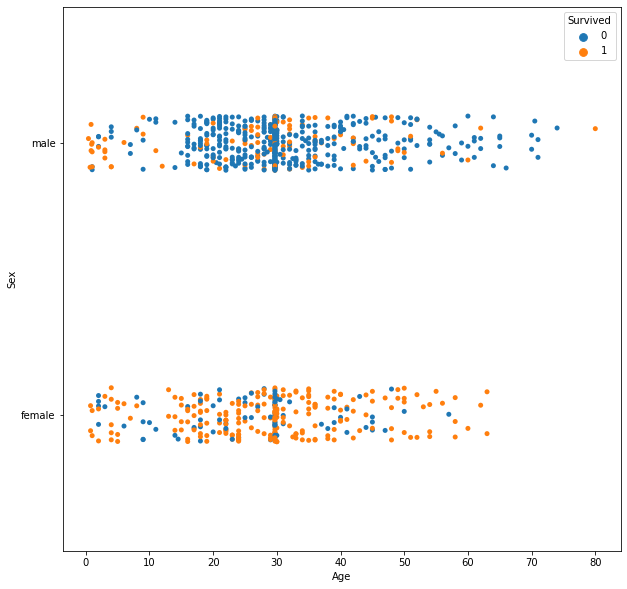

In [13]:
plt.figure(figsize = (10, 10))
sns.stripplot(x = 'Age', y = 'Sex', hue = 'Survived', data = titanic)
plt.show()

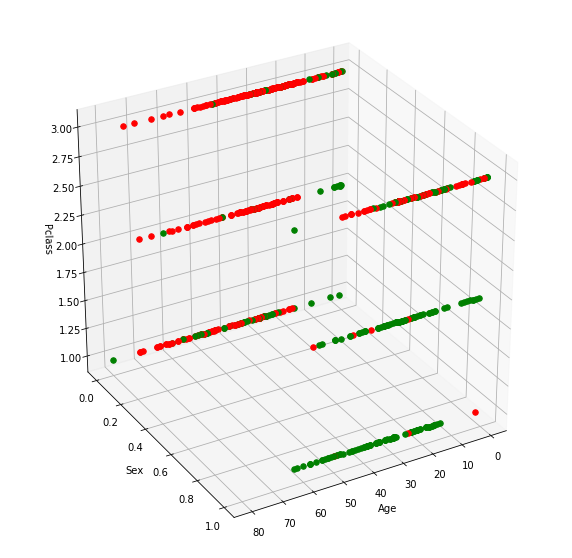

In [14]:
xs = titanic['Age']
ys = titanic['Sex'].apply(lambda x : 0 if x =='male' else 1)
zs = titanic['Pclass']
label = titanic['Survived']
data = zip(xs, ys, zs, label)

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')

for x, y, z, l in data:
    if l == 0:
        color = 'red'
    else:
        color = 'green'
    ax.scatter(x, y, z, s=30, label = l, c = color)

ax.view_init(30, 60)
ax.set_xlabel('Age')
ax.set_ylabel('Sex')
ax.set_zlabel('Pclass')

plt.show()


# I've commented out some code to animate this graph into a sweet spinning graph. It's great!


# def animate(i):
#     ax.view_init(30, i)
#     return plt.draw()

# anim = animation.FuncAnimation(fig, animate, frames = 360, interval = 20, blit = False)
    
# HTML(anim.to_html5_video())
#HTML(anim.to_jshtml())

<Figure size 720x720 with 0 Axes>

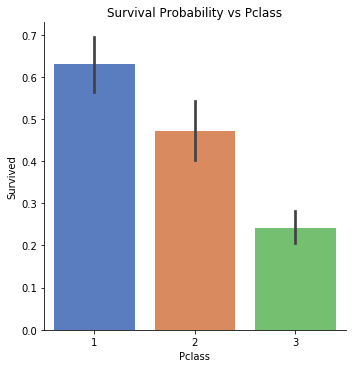

<Figure size 720x720 with 0 Axes>

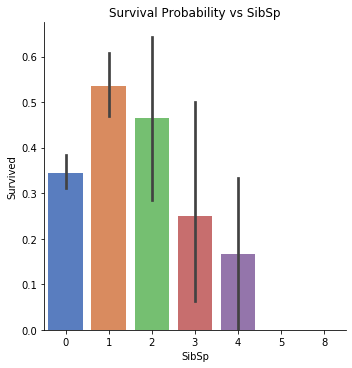

<Figure size 720x720 with 0 Axes>

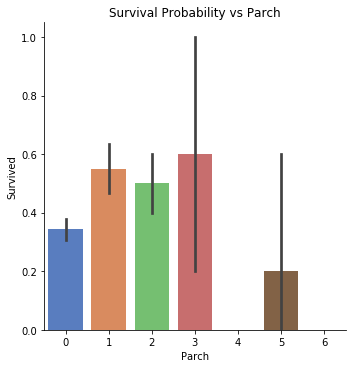

<Figure size 720x720 with 0 Axes>

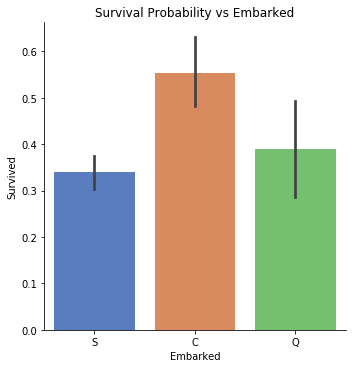

<Figure size 720x720 with 0 Axes>

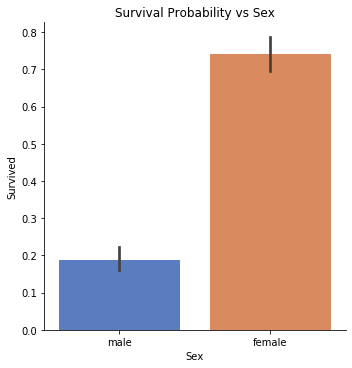

In [15]:
for feature in ['Pclass', 'SibSp', 'Parch', 'Embarked', 'Sex']:

    plt.figure(figsize = (10, 10))
    graph = sns.catplot(x = feature, y = 'Survived', hue = None, data = titanic, kind="bar", palette="muted")
    plt.title(f'Survival Probability vs {feature}')
    plt.show()

Wow! What beautiful graphs I've made!!  

From this, we can already draw a few conclusions: It seems like Men died more, 2nd and 3rd class folks died more, and the young and old lived more.

# Correlation Matrix



,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.069809,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.331339,0.083081,0.018443,-0.549500
Age,-0.069809,-0.331339,1.000000,-0.232625,-0.179191,0.091566
SibSp,-0.035322,0.083081,-0.232625,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.179191,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.091566,0.159651,0.216225,1.000000


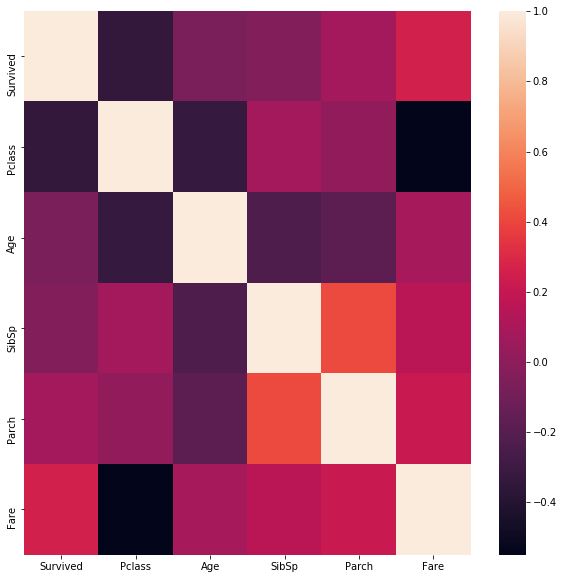

<Figure size 720x720 with 0 Axes>

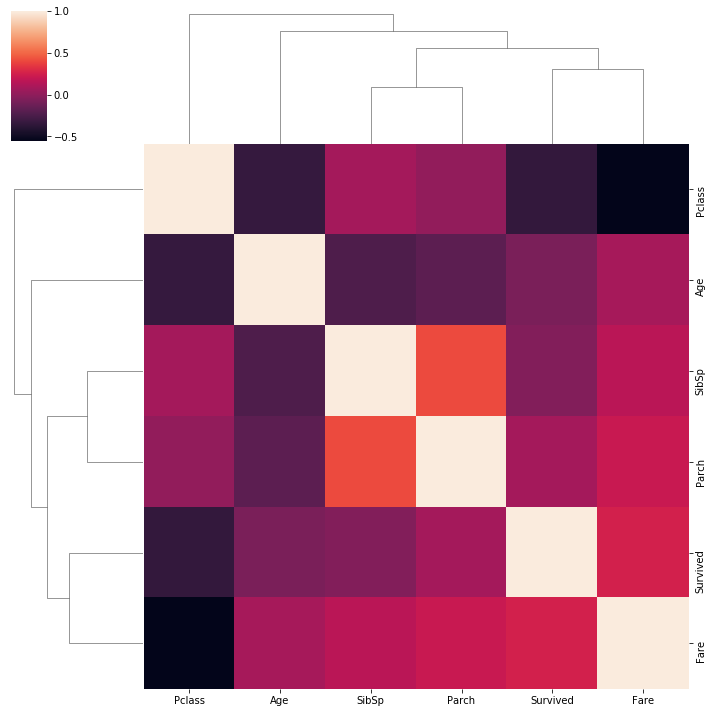

In [32]:
corr = titanic.corr()
display(corr)

plt.figure(figsize = (10, 10))
sns.heatmap(corr)
plt.show()

plt.figure(figsize = (10, 10))
sns.clustermap(corr)
plt.show()

# Final Preprocessing

Now that we've finished graphing, we can do our final preprocessing, which will make the data better suited for modeling, but harder for humans to understand.

Now, LightGBM says it can handle Categorical Features in it's documentation. But it has failed when I've attempted it. I'm not sure if I'm making the mistake, or it the sklearn wrapper on LightGBM is interfering with this feature. Also, it may be that Anaconda is installing an older version of LightGBM which is missing this feature.

In any case, it's not that hard to take care of it myself. I'd better encode Sex, Embarked, and Honorific. Let's do One-Hot Encoding. LightGBM says One-Hot is not as good, but we'll just have to make do for now.

In [131]:
# One hot encoding
titanic = pd.get_dummies(titanic)
test = pd.get_dummies(test)

In [132]:
X_data = titanic.drop('Survived', axis = 1)
y_data = titanic['Survived']
X_test = test

In [133]:
X_data.describe()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208,0.352413,0.647587,0.188552,0.086420,0.725028
std,0.836071,13.002015,1.102743,0.806057,49.693429,0.477990,0.477990,0.391372,0.281141,0.446751
min,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,29.699118,0.000000,0.000000,14.454200,0.000000,1.000000,0.000000,0.000000,1.000000
75%,3.000000,35.000000,1.000000,0.000000,31.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000


In [134]:
# Also, scale the data!!

def scale(X):
    scaler = StandardScaler()
    scaler.fit(X) 
    X = pd.DataFrame(scaler.transform(X),columns = X.columns)
    return X

#Scale your data
X_data = scale(X_data)

#Do I need to scale y as well?

# Scale the test data too, of course!!
X_test = scale(X_test)

In [135]:
X_data.describe()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
count,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02
mean,-2.031048e-16,2.562796e-16,3.456519e-16,6.716164e-17,-4.373606e-17,3.162453e-16,-4.059603e-16,1.167541e-16,-4.017238e-16,-2.093350e-16
std,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00
min,-1.566107e+00,-2.253155e+00,-4.745452e-01,-4.736736e-01,-6.484217e-01,-7.376951e-01,-1.355574e+00,-4.820427e-01,-3.075623e-01,-1.623803e+00
25%,-3.693648e-01,-5.924806e-01,-4.745452e-01,-4.736736e-01,-4.891482e-01,-7.376951e-01,-1.355574e+00,-4.820427e-01,-3.075623e-01,-1.623803e+00
50%,8.273772e-01,0.000000e+00,-4.745452e-01,-4.736736e-01,-3.573909e-01,-7.376951e-01,7.376951e-01,-4.820427e-01,-3.075623e-01,6.158384e-01
75%,8.273772e-01,4.079260e-01,4.327934e-01,-4.736736e-01,-2.424635e-02,1.355574e+00,7.376951e-01,-4.820427e-01,-3.075623e-01,6.158384e-01
max,8.273772e-01,3.870872e+00,6.784163e+00,6.974147e+00,9.667167e+00,1.355574e+00,7.376951e-01,2.074505e+00,3.251373e+00,6.158384e-01


# Model 1 (Linear Classifier)

Let's start with the simpelest model, a Linear Regression Classifier. In particular, we'll use a Logistic Classifier, which ... (add a description here)

In [136]:
n_iter = 100

param_test = {
                'max_iter': range(1, 1001),
                 'penalty': ['l1', 'l2', 'elasticnet']
            }


model = LogisticRegression(n_jobs=2, verbose = -1)


rs = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_test, 
            scoring='roc_auc',
            cv=5,
            refit=True,
            verbose=True,
            n_iter = n_iter,
            n_jobs = 2
            )

rs.fit(X_data, y_data)

print(f'Best score reached: {rs.best_score_} with params: {rs.best_params_} ')

model = LogisticRegression(**rs.best_params_)

model.fit(X_data, y_data)

predict = model.predict(X_test)

output = pd.DataFrame({'PassengerID': test_id, 'Survived': predict})

output.to_csv(f'{filepath}submit_linear.csv',index=False, header =1)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 360 tasks      | elapsed:    7.7s


Best score reached: 0.8492519981484998 with params: {'penalty': 'l2', 'max_iter': 124} 


[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   10.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.0s finished


Wow! For a simple linear model, the results are pretty good! 85% accuracy! Let's upload to Kaggle for comparison.

Kaggle: 0.76076

So about 76%. Wow, that's fantastic for a linear model!

# Model 2 (LightGBM)

Let's chuck it in a Light GBM Random Search, and see what we come up with.

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   12.9s
[Parallel(n_jobs=2)]: Done 208 tasks      | elapsed:   58.8s
[Parallel(n_jobs=2)]: Done 458 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:  2.4min finished


Best score reached: 0.8720287739783152 with params: {'num_leaves': 3, 'n_estimators': 900, 'learning_rate': 0.01} 


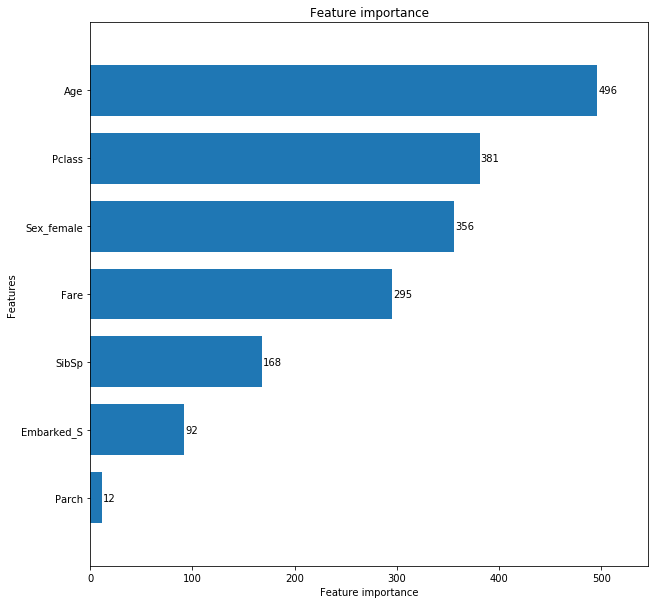

In [137]:
n_iter = 100

param_test = {
                'num_leaves': range(2, 20), 
                'learning_rate': [.01, .02, .03, .04, .05, .06, .07, .08, .09, .1],
                'n_estimators' : range(100, 5000, 10)
            }


model = lgb.LGBMClassifier(silent=True, n_jobs=2, verbose = -1)


rs = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_test, 
            scoring='roc_auc',
            cv=5,
            refit=True,
            verbose=True,
            n_iter = n_iter,
            n_jobs = 2
            )

rs.fit(X_data, y_data, verbose = False)

print(f'Best score reached: {rs.best_score_} with params: {rs.best_params_} ')

model = lgb.LGBMClassifier(**rs.best_params_)

model.fit(X_data, y_data, verbose = False)

predict = model.predict(X_test)

output = pd.DataFrame({'PassengerID': test_id, 'Survived': predict})

output.to_csv(f'{filepath}submit_lgb1.csv',index=False, header =1)

lgb.plot_importance(model, height = .75, figsize = (10, 10), grid = False)
plt.show()

# Scoring 1

[Parallel(n_jobs=2)]: Done 5000 out of 5000 | elapsed:  6.9min finished  
Best score reached: 0.8726335778536676 with params: {'num_leaves': 3, 'n_estimators': 271, 'learning_rate': 0.03}  
Kaggle: 0.77511%which is about 6000 place out of 16488 on Kaggle, or roughly 38 percentile.

[Parallel(n_jobs=2)]: Done 25000 out of 25000 | elapsed: 23.0min finished  
Best score reached: 0.8730598584213757 with params: {'num_leaves': 3, 'n_estimators': 140, 'learning_rate': 0.06}   
Kaggle:  0.77511%, which is about 6000 place out of 16488 on Kaggle, or roughly 38 percentile.

[Parallel(n_jobs=2)]: Done 50000 out of 50000 | elapsed: 224.1min finished
Best score reached: 0.8723611552537032 with params: {'num_leaves': 3, 'n_estimators': 180, 'learning_rate': 0.05}  
Kaggle:  0.77511%, which is about 6000 place out of 16488 on Kaggle, or roughly 38 percentile.

Label Encode + honorific = 14000 place, 0.74162% accuracy  
Label Encode - honorific = 9800 place, 0.77511% accuracy  
One Hot - Honorific = 3740 place, 0.78947% accuracy  
Above, but 1000 rs iterations =  0.77511% accuracy

# Conclusions 1

At this point, we aren't really adding much predictive power to our model by hyperparameter tuning, since "better" hyperparameter tuning leads to lower scores on Kaggle. While we could continue to tinker, we would only be overfitting our model to the test data (the data on Kaggle).  

This is important to remember in any competition: the purpose of a model is to be able to generalize well. It isn't worth trying to tune hyperparameters for minor score improvements on the leaderboard. The purpose of test data is to say "Now that I'm 100% convinced I've made the best model I can based on the training data, let me see how well it generalizes based on the test data." Don't change your model based on the test data, unless you come up with some new methods for data cleaning, feature generation / selection, or different hyperparameters to try, and you want to rebuild your model from scratch.

In the end, our model is pretty good. It predicts with, in general, 87% accuracy. It happened to get 79% on Kaggle, but with another test set it might do better or worse. The point is that our model can generalize substantially better than 50%, which means we're doing much better than randomly guessing.

# Further Feature Generation

At this point, we might start to think about additional feature engineering. I ran across an interesting Kernal on Kaggle, that generates a couple more very interesting features. All credit to Bhargav Purohit.  
https://www.kaggle.com/bhargavpurohit/titanic-top-6-using-only-random-forest

He adds two additional features: title and group size. For now, let me just work on the title.  

Note that I've glanced through his Kernal for the idea to do these features, but I'm going to try to code them myself.

First, let me redo all my previous preprocessing.

In [138]:
# Preprocessing

titanic = pd.read_csv(f'{filepath}train.csv')
test = pd.read_csv(f'{filepath}test.csv')

titanic = titanic.drop(['Cabin'], axis = 1)
test = test.drop(['Cabin'], axis = 1)

titanic.loc[61, 'Embarked'] = 'S'
titanic.loc[829, 'Embarked'] = 'S'

# I'm a little confused as to why this worked, but whatever.
titanic['Age'] = SimpleImputer().fit_transform(titanic[['Age']])
test['Age'] = SimpleImputer().fit_transform(test[['Age']])

test['Fare'] = SimpleImputer().fit_transform(test[['Fare']])

In [139]:
title = set()
for name in titanic['Name']:
    words = name.split()
    for word in words:
        if '.' in word:
            title.add(word)
                      
display(title)

title_test = set()
for name in test['Name']:
    words = name.split()
    for word in words:
        if '.' in word:
            title_test.add(word)
            
display(title_test)

title = title | title_test

{'Capt.',
 'Col.',
 'Countess.',
 'Don.',
 'Dr.',
 'Jonkheer.',
 'L.',
 'Lady.',
 'Major.',
 'Master.',
 'Miss.',
 'Mlle.',
 'Mme.',
 'Mr.',
 'Mrs.',
 'Ms.',
 'Rev.',
 'Sir.'}

{'Col.', 'Dona.', 'Dr.', 'Master.', 'Miss.', 'Mr.', 'Mrs.', 'Ms.', 'Rev.'}

It mostly looks good. But, what about 'Don.', 'Jonkheer.', 'L.', 'Mlle.', 'Mme.'? Let's check each of these.

Based on my research / googling, 'Mlle.' is short for mademoiselle, which is French for 'Ms.'

'Mme.' is French for 'Madame.', which might be the same as Mrs.? Unclear.

Jonkheer (female equivalent: jonkvrouw; French: Écuyer) is an honorific in the Low Countries denoting the lowest rank within the nobility.

"Don' is an honorific in Mexico and other countries.

However, 'L.' is just an abbreviated middle name, so we'll remove it from the list.

In [140]:
title.remove('L.')

Let's make sure that no one has more or less than one prefix.

In [141]:
for i, row in titanic.iterrows():
    count = 0
    for honor in list(title):
        if honor in row['Name'].split():
            count += 1
    if count != 1:
        print(i, count)

In [142]:
for i, row in test.iterrows():
    count = 0
    for honor in list(title):
        if honor in row['Name'].split():
            count += 1
    if count != 1:
        print(i, count)
        display()

In [143]:
display(title)

{'Capt.',
 'Col.',
 'Countess.',
 'Don.',
 'Dona.',
 'Dr.',
 'Jonkheer.',
 'Lady.',
 'Major.',
 'Master.',
 'Miss.',
 'Mlle.',
 'Mme.',
 'Mr.',
 'Mrs.',
 'Ms.',
 'Rev.',
 'Sir.'}

Good, looks like we're set to add this feature.

Ok, we need to standardize these labels if we want to do one-hot later on. Also, the feature will probably be of more value if we help group them together into meaningful categories. So we'd have to come up with some sort of translation (i.e. 'Mlle' = 'Ms.'). I'll use the grouping and a modified key from that Kernal. (I have to account for periods in my version.

1. Mr
2. Mrs
3. Master
4. Royal
5. Officer
6. Miss

In [144]:
title_map={
    "Mr.": "Mr", 
    "Mrs.": "Mrs", 
    "Miss.": "Miss", 
    "Master.": "Master", 
    "Don.": "Royal", 
    "Rev.": "Officer", 
    "Dr.": "Officer",
    "Mme.": "Mrs", 
    "Dona.": "Royal", 
    "Jonkheer." : "Royal", 
    "Countess.": "Royal", 
    "Capt.": "Officer", 
    "Col.": "Officer",
    "Ms.": "Mrs", 
    "Mlle.": "Miss", 
    "Major.": "Officer", 
    "Lady." : "Royal", 
    "Sir." : "Royal"
    }

def get_title(string):
    for word in title:
        if word in string.split():
            return title_map[word]
    
titanic['Title'] = titanic['Name'].apply(get_title)
test['Title'] = test['Name'].apply(get_title)

In [145]:
display(titanic)
display(test)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,S,Officer
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,S,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,S,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C,Mr


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.50000,0,0,330911,7.8292,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00000,1,0,363272,7.0000,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.00000,0,0,240276,9.6875,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.00000,0,0,315154,8.6625,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00000,1,1,3101298,12.2875,S,Mrs
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,30.27259,0,0,A.5. 3236,8.0500,S,Mr
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.00000,0,0,PC 17758,108.9000,C,Royal
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.50000,0,0,SOTON/O.Q. 3101262,7.2500,S,Mr
416,1308,3,"Ware, Mr. Frederick",male,30.27259,0,0,359309,8.0500,S,Mr


Good. Let's finish cleaning and encoding our data, then we'll train a new model.

In [146]:
# Drop unneeded cells.
to_drop = ['PassengerId', 'Name', 'Ticket']


titanic = titanic.drop(to_drop, axis = 1)
test = test.drop(to_drop, axis = 1)

# One hot encoding
titanic = pd.get_dummies(titanic)
test = pd.get_dummies(test)

X_data = titanic.drop('Survived', axis = 1)
y_data = titanic['Survived']
X_test = test

#Scale your data
X_data = scale(X_data)

# Scale the test data too
X_test = scale(X_test)

In [147]:
display(titanic)
display(test)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royal
0,0,3,22.000000,1,0,7.2500,0,1,0,0,1,0,0,1,0,0,0
1,1,1,38.000000,1,0,71.2833,1,0,1,0,0,0,0,0,1,0,0
2,1,3,26.000000,0,0,7.9250,1,0,0,0,1,0,1,0,0,0,0
3,1,1,35.000000,1,0,53.1000,1,0,0,0,1,0,0,0,1,0,0
4,0,3,35.000000,0,0,8.0500,0,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.000000,0,0,13.0000,0,1,0,0,1,0,0,0,0,1,0
887,1,1,19.000000,0,0,30.0000,1,0,0,0,1,0,1,0,0,0,0
888,0,3,29.699118,1,2,23.4500,1,0,0,0,1,0,1,0,0,0,0
889,1,1,26.000000,0,0,30.0000,0,1,1,0,0,0,0,1,0,0,0


,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royal
0,3,34.50000,0,0,7.8292,0,1,0,1,0,0,0,1,0,0,0
1,3,47.00000,1,0,7.0000,1,0,0,0,1,0,0,0,1,0,0
2,2,62.00000,0,0,9.6875,0,1,0,1,0,0,0,1,0,0,0
3,3,27.00000,0,0,8.6625,0,1,0,0,1,0,0,1,0,0,0
4,3,22.00000,1,1,12.2875,1,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,30.27259,0,0,8.0500,0,1,0,0,1,0,0,1,0,0,0
414,1,39.00000,0,0,108.9000,1,0,1,0,0,0,0,0,0,0,1
415,3,38.50000,0,0,7.2500,0,1,0,0,1,0,0,1,0,0,0
416,3,30.27259,0,0,8.0500,0,1,0,0,1,0,0,1,0,0,0


# Model 3 (LightGBM, Additional Feature)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   11.9s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   55.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:  2.4min finished


Best score reached: 0.8711166203436083 with params: {'num_leaves': 3, 'n_estimators': 470, 'learning_rate': 0.06} 


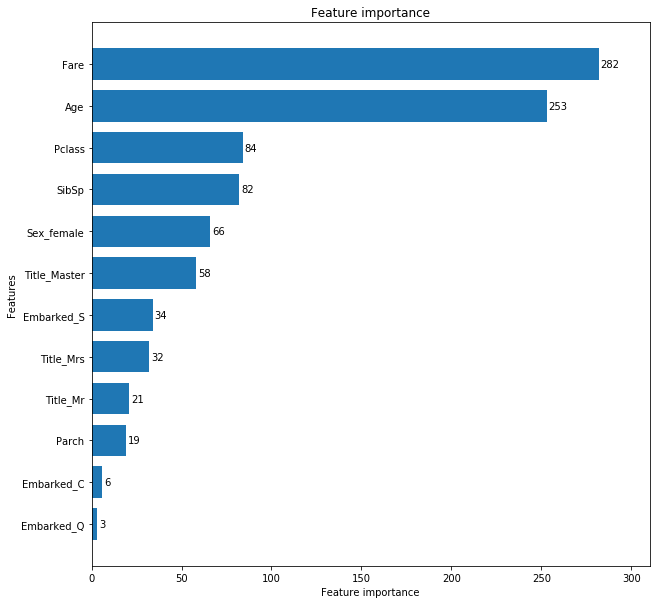

In [148]:
n_iter = 100

param_test = {
                'num_leaves': range(2, 20), 
                'learning_rate': [.01, .02, .03, .04, .05, .06, .07, .08, .09, .1],
                'n_estimators' : range(100, 5000, 10)
            }


model = lgb.LGBMClassifier(silent=True, n_jobs=2, verbose = -1)


rs = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_test, 
            scoring='roc_auc',
            cv=5,
            refit=True,
            verbose=True,
            n_iter = 100,
            n_jobs = 2
            )

rs.fit(X_data, y_data, verbose = False)

print(f'Best score reached: {rs.best_score_} with params: {rs.best_params_} ')

model = lgb.LGBMClassifier(**rs.best_params_)

model.fit(X_data, y_data, verbose = False)

predict = model.predict(X_test)

output = pd.DataFrame({'PassengerID': test_id, 'Survived': predict})

output.to_csv(f'{filepath}submit_lgb2.csv',index=False, header =1)

lgb.plot_importance(model, height = .75, figsize = (10, 10), grid = False)
plt.show()

# Scoring 2

[Parallel(n_jobs=2)]: Done 5000 out of 5000 | elapsed:  4.6min finished  
Best score reached: 0.8749554207221563 with params: {'num_leaves': 3, 'n_estimators': 390, 'learning_rate': 0.02}  
Kaggle: 0.77511%

[Parallel(n_jobs=2)]: Done 50000 out of 50000 | elapsed: 215.4min finished  
Best score reached: 0.8754081530715776 with params: {'num_leaves': 3, 'n_estimators': 740, 'learning_rate': 0.01}   
Kaggle: .77511%

Well, not a huge improvement, but slightly better than our previous attempt. Got the same score on Kaggle, so...

# Further Conclusions

This new feature does appear to help very slightly, but not enough to greatly change the Kaggle score. Perhaps the other feature from that Kernal, group size, makes a larger difference. Or perhaps both of them together have some sort of interaction.

# Further Visualizations

It can be hard to understand what is happening with this type of modeling. Here are all the trees used in our final model. Remember that this method generates a tree, then generates a new tree to correct the mistakes of the old tree, and keeps doing this until a certian threshold. Then it takes a weighted average of all the trees.  

Looking at the trees, you'll notice that each one wouldn't do a very good job on it's own. That's on purpose! We don't want to over fit the data. Each of these trees is a "weak classifier", and captures some aspect of the data structure. Then the next tree tries to capture a different aspect of the data structure by learning from the previous tree. On their own, they are not good, but together they form a powerful "ensemble" for exploring the data structure.

Hold on to your mouse wheel...

Here are some of the 470 trees used in our final model.


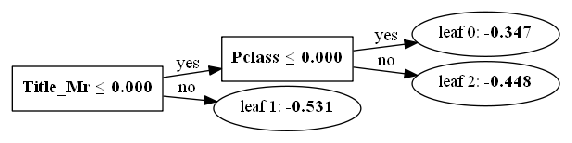

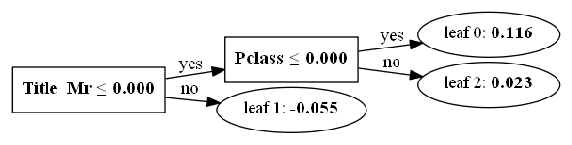

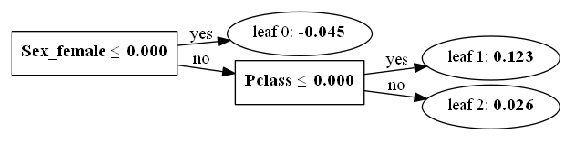

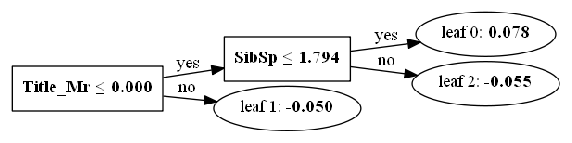

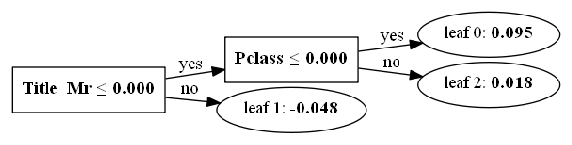

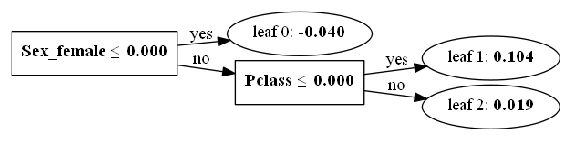

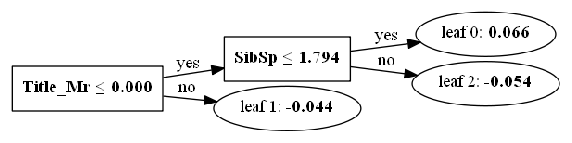

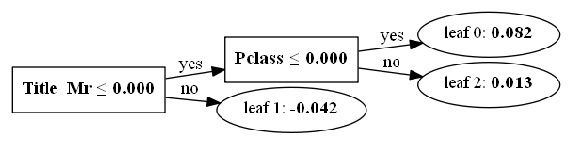

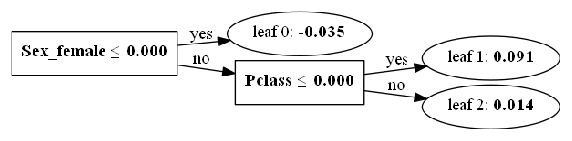

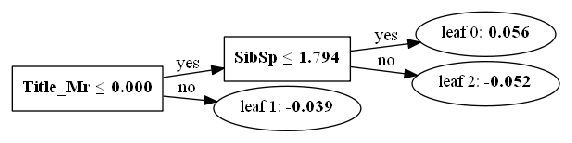

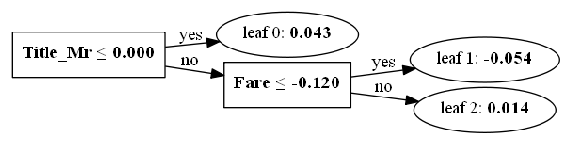

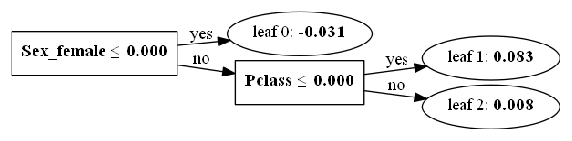

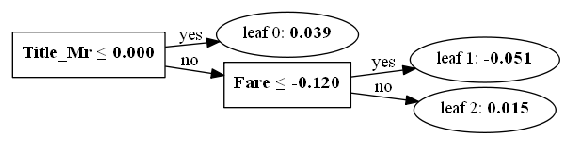

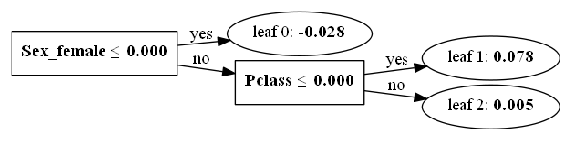

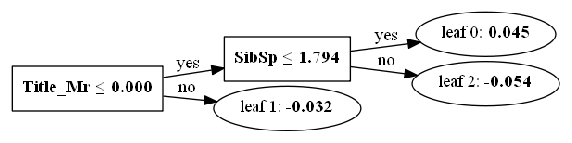

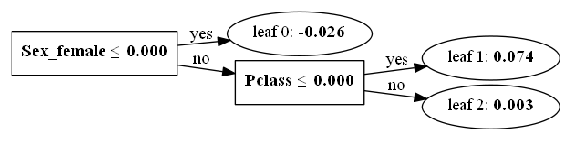

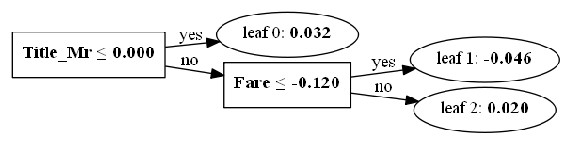

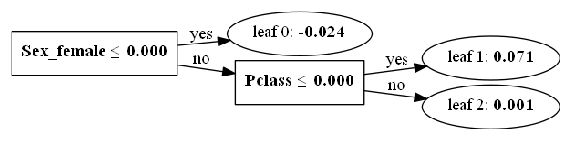

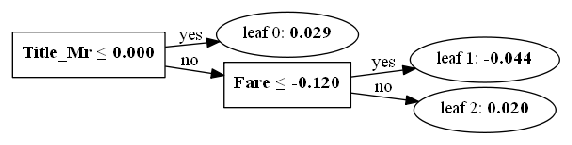

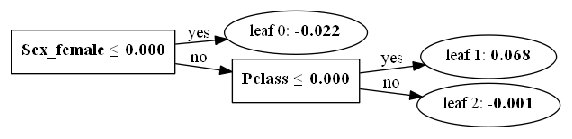

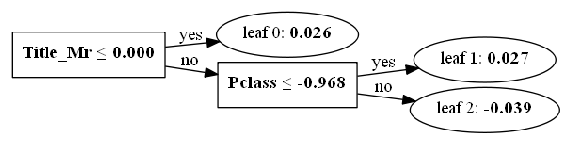

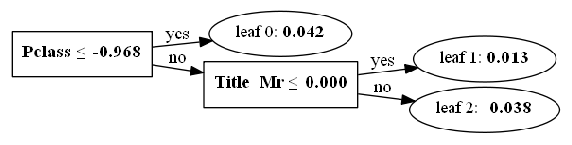

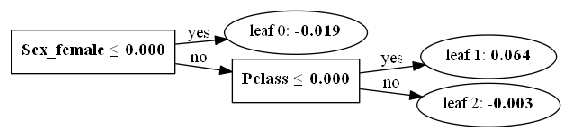

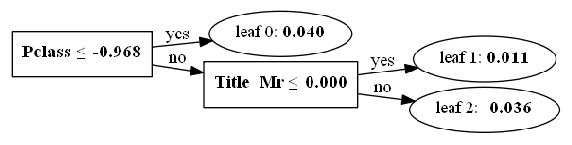

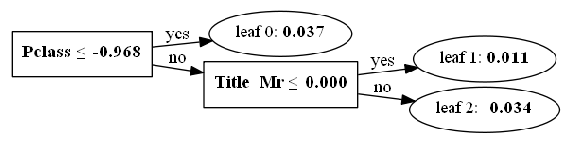

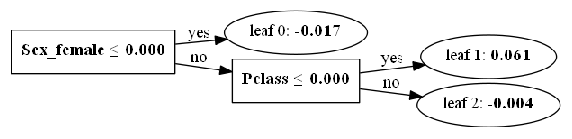

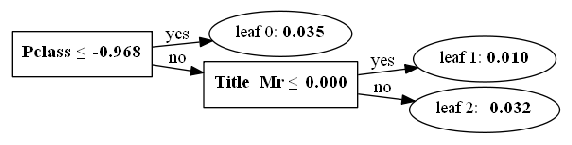

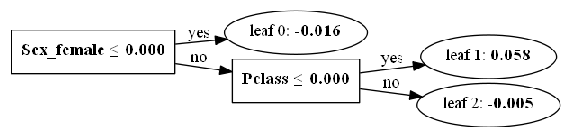

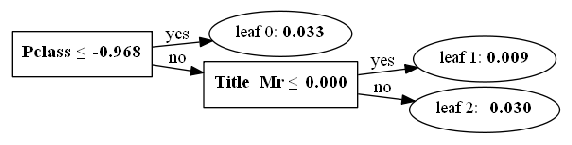

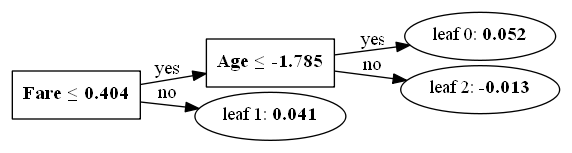

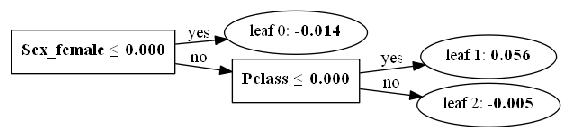

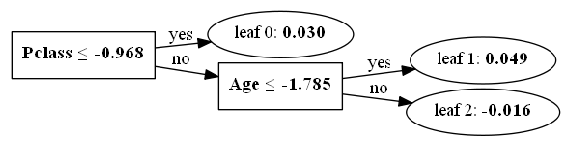

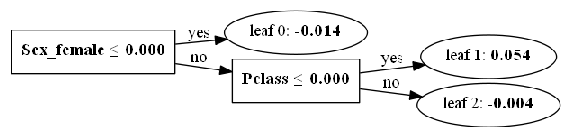

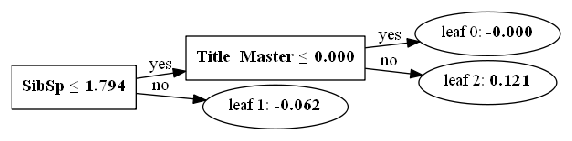

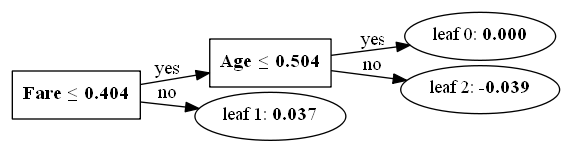

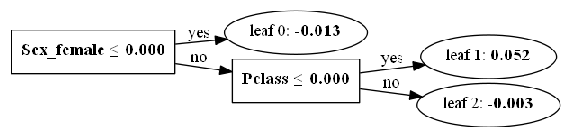

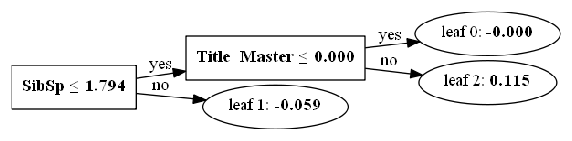

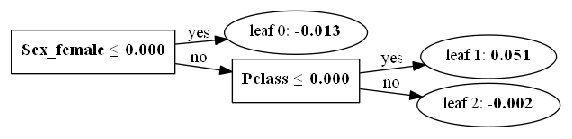

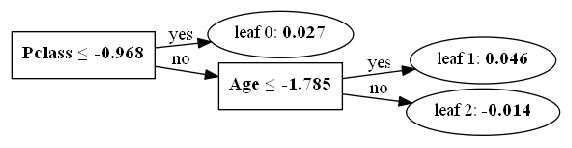

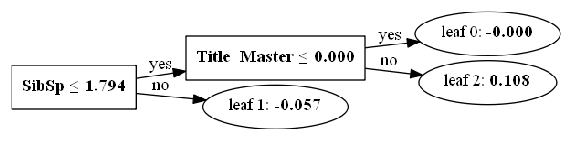

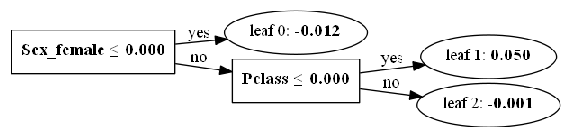

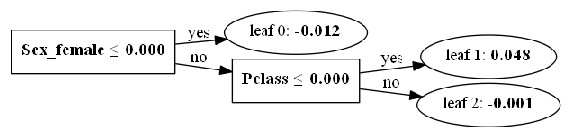

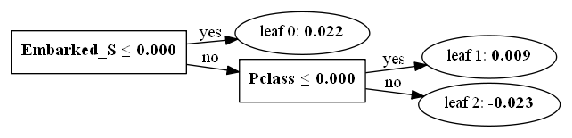

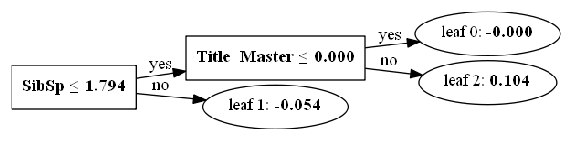

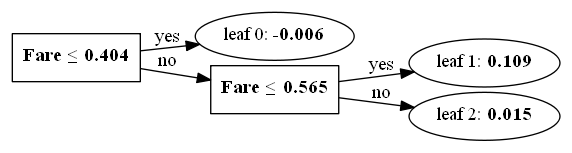

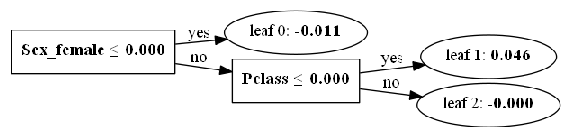

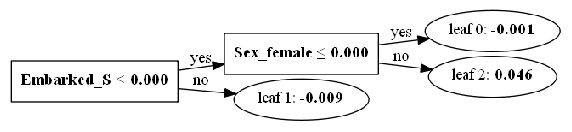

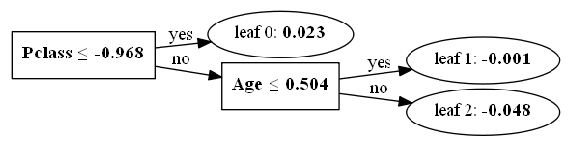

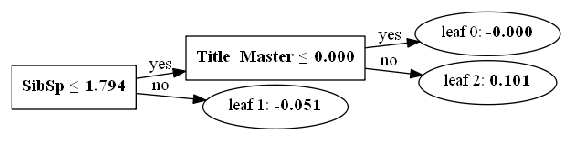

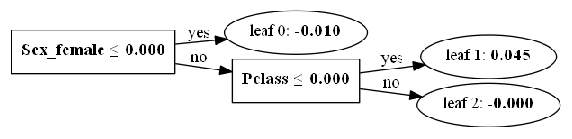

In [150]:
num_trees = rs.best_params_['n_estimators']

print(f'Here are some of the {num_trees} trees used in our final model.')

for i in range(min(50, num_trees)):
    lgb.plot_tree(model, figsize = (10, 10), tree_index = i)